In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
# change directory


Mounted at /content/gdrive
/content/gdrive/My Drive/AICP


In [4]:
!pip install --upgrade category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [5]:
import os

import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from numpy import concatenate
from math import sqrt

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from category_encoders import CountEncoder, TargetEncoder
from scipy.sparse import hstack

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [6]:
df = pd.read_csv("/content/gdrive/MyDrive/AICP (1)/data/raw/HI-Small_Trans.csv")
print(df.columns);
print(df.shape)
df.head()

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')
(5078345, 11)


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [7]:
df = df.rename(columns={'Is Laundering': 'Is_Laundering'})

In [8]:
df[-5:]

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
5078340,2022/09/10 23:57,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,0
5078341,2022/09/10 23:35,15,8148A8671,256398,8148A8711,0.108128,Bitcoin,0.108128,Bitcoin,Bitcoin,0
5078342,2022/09/10 23:52,154365,8148A6771,256398,8148A8711,0.004988,Bitcoin,0.004988,Bitcoin,Bitcoin,0
5078343,2022/09/10 23:46,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,0
5078344,2022/09/10 23:37,154518,8148A6091,256398,8148A8711,0.281983,Bitcoin,0.281983,Bitcoin,Bitcoin,0


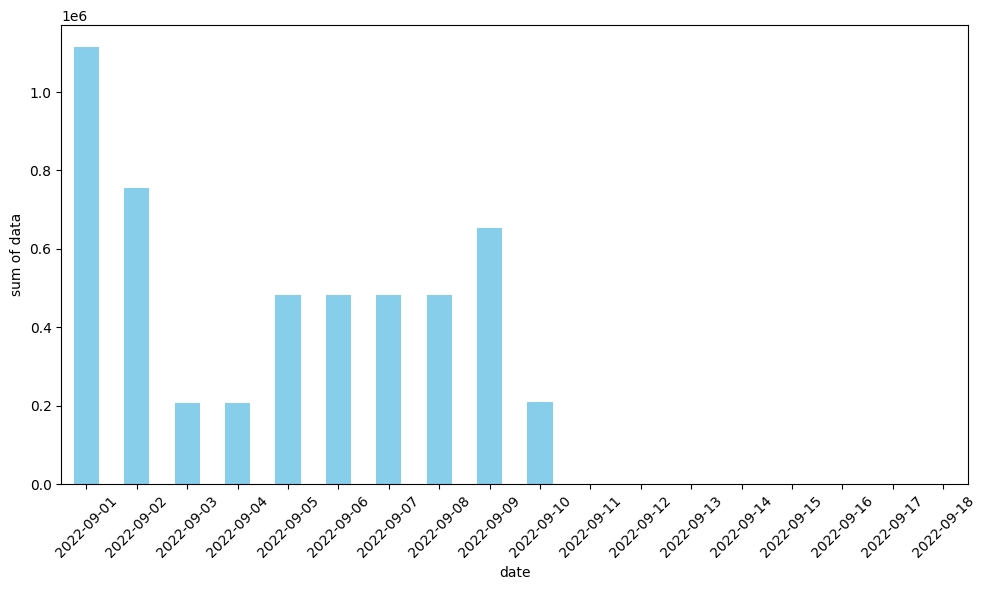

In [9]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Date'] = df['Timestamp'].dt.date
df.set_index('Date', inplace=True)

daily_data_count = df.groupby(df.index).size()

plt.figure(figsize=(10, 6))
daily_data_count.plot(kind='bar', color='skyblue')
plt.xlabel('date')
plt.ylabel('sum of data')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

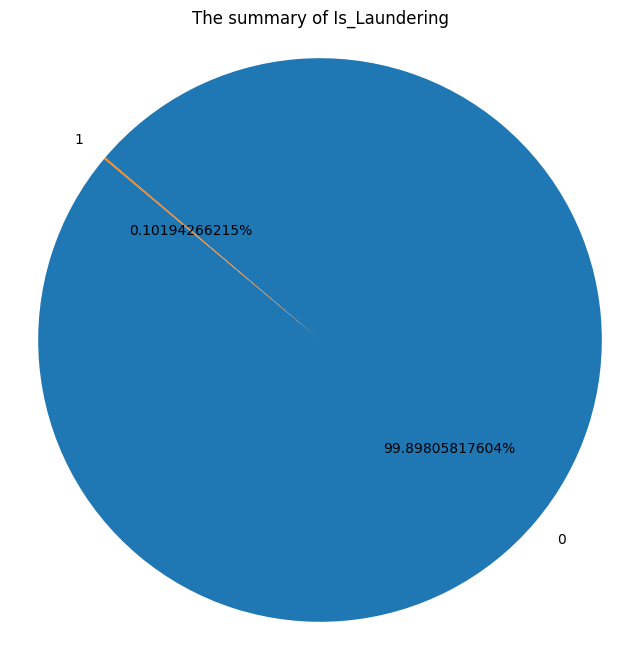

In [10]:
laundering_counts = df['Is_Laundering'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(laundering_counts, labels=laundering_counts.index, autopct='%1.11f%%', startangle=140)
plt.title('The summary of Is_Laundering')
plt.axis('equal')

plt.show()

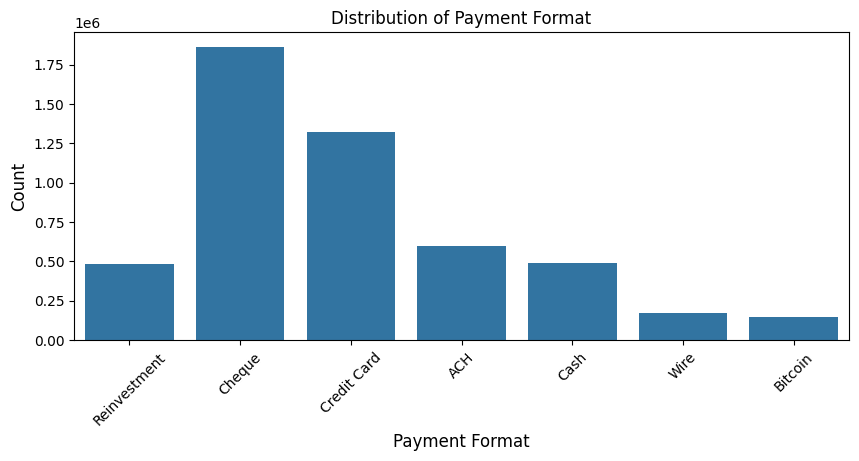

In [11]:
f, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='Payment Format', data=df, ax=ax)
ax.set_title('Distribution of Payment Format')
ax.set_xlabel('Payment Format', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.tick_params(axis='x', labelrotation=45)
plt.show()

In [12]:
df['Payment Format'].unique()

array(['Reinvestment', 'Cheque', 'Credit Card', 'ACH', 'Cash', 'Wire',
       'Bitcoin'], dtype=object)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5078345 entries, 2022-09-01 to 2022-09-10
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           int64         
 2   Account             object        
 3   To Bank             int64         
 4   Account.1           object        
 5   Amount Received     float64       
 6   Receiving Currency  object        
 7   Amount Paid         float64       
 8   Payment Currency    object        
 9   Payment Format      object        
 10  Is_Laundering       int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 497.2+ MB


In [14]:
print(df.shape)
df = df.drop_duplicates(keep = 'first')
df.shape

(5078345, 11)


(5078336, 11)

In [15]:
has_nan = df.isnull().values.any()

if has_nan:
    print("NaN")
    print(df.isnull().sum())
else:
    print("not NaN")


not NaN


In [16]:
df.describe()

,From Bank,To Bank,Amount Received,Amount Paid,Is_Laundering
count,5.078336e+06,5.078336e+06,5.078336e+06,5.078336e+06,5.078336e+06
mean,4.573058e+04,6.574461e+04,5.988737e+06,4.509281e+06,1.019428e-03
std,8.176567e+04,8.409303e+04,1.037184e+09,8.697736e+08,3.191221e-02
min,1.000000e+00,1.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,1.190000e+02,4.259000e+03,1.833700e+02,1.844800e+02,0.000000e+00
50%,9.679000e+03,2.156800e+04,1.411040e+03,1.414570e+03,0.000000e+00
75%,2.862800e+04,1.223320e+05,1.234630e+04,1.229815e+04,0.000000e+00
max,3.563030e+05,3.562940e+05,1.046302e+12,1.046302e+12,1.000000e+00


In [17]:
object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols

['Account',
 'Account.1',
 'Receiving Currency',
 'Payment Currency',
 'Payment Format']

In [18]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
Date,,,,,,,,,,,
2022-09-01,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
2022-09-01,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2022-09-01,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
2022-09-01,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
2022-09-01,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [19]:
for col in object_cols:
    print(col,'\n')
    print(df[col].nunique(), '\n')
    print(df[col].value_counts())

Account 

496995 

100428660    168672
1004286A8    103018
100428978     20497
1004286F0     18663
100428780     17264
              ...  
806198930         1
806197550         1
80127BE50         1
8061935F0         1
8148A8671         1
Name: Account, Length: 496995, dtype: int64
Account.1 

420636 

100428660    1084
1004286A8     653
80F47A310     159
100428978     150
8018859B0     144
             ... 
80B14E9D0       1
80B159D00       1
812577710       1
812569750       1
80F91C540       1
Name: Account.1, Length: 420636, dtype: int64
Receiving Currency 

15 

US Dollar            1879341
Euro                 1172017
Swiss Franc           237884
Yuan                  206551
Shekel                194988
Rupee                 192065
UK Pound              181255
Ruble                 157361
Yen                   156319
Bitcoin               148142
Canadian Dollar       141357
Australian Dollar     138511
Mexican Peso          111030
Saudi Riyal            89971
Brazil Real         

In [20]:
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(object_cols)


label_encoder = LabelEncoder()
for col in object_cols:
    if col != 'Payment Format':
        df[col] = label_encoder.fit_transform(df[col])


payment_map = {'Cash': 1, 'Cheque': 2, 'ACH': 3, 'Credit Card': 4, 'Wire': 5, 'Bitcoin': 6, 'Reinvestment': 7}


df['Payment Format'] = df['Payment Format'].map(payment_map)


df.head()

['Account', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format']


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
Date,,,,,,,,,,,
2022-09-01,2022-09-01 00:20:00,10,942,10,900,3697.34,12,3697.34,12,7,0
2022-09-01,2022-09-01 00:20:00,3208,990,1,949,0.01,12,0.01,12,2,0
2022-09-01,2022-09-01 00:00:00,3209,991,3209,940,14675.57,12,14675.57,12,7,0
2022-09-01,2022-09-01 00:02:00,12,997,12,945,2806.97,12,2806.97,12,7,0
2022-09-01,2022-09-01 00:06:00,10,999,10,947,36682.97,12,36682.97,12,7,0


In [21]:
labels = df['Is_Laundering']
df = df.drop('Is_Laundering', axis=1)


df['Timestamp'] = pd.to_datetime(df['Timestamp']).astype(int) / 10**9


scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df_normalized = scaler.transform(df)


df_normalized = pd.DataFrame(df_normalized, columns=df.columns)


df_normalized['Is_Laundering'] = labels.tolist()


print(df_normalized.head())

   Timestamp  From Bank   Account   To Bank  Account.1  Amount Received  \
0  -0.998429  -0.999949 -0.996209 -0.999949  -0.995721             -1.0   
1  -0.998429  -0.981998 -0.996016 -1.000000  -0.995488             -1.0   
2  -1.000000  -0.981993 -0.996012 -0.981992  -0.995531             -1.0   
3  -0.999843  -0.999938 -0.995988 -0.999938  -0.995507             -1.0   
4  -0.999529  -0.999949 -0.995980 -0.999949  -0.995497             -1.0   

   Receiving Currency  Amount Paid  Payment Currency  Payment Format  \
0            0.714286         -1.0          0.714286        1.000000   
1            0.714286         -1.0          0.714286       -0.666667   
2            0.714286         -1.0          0.714286        1.000000   
3            0.714286         -1.0          0.714286        1.000000   
4            0.714286         -1.0          0.714286        1.000000   

   Is_Laundering  
0              0  
1              0  
2              0  
3              0  
4              0  


In [22]:
df_laundering = df_normalized.loc[df_normalized['Is_Laundering'] == 1]


print(df_normalized.count())
df_laundering.count()

Timestamp             5078336
From Bank             5078336
Account               5078336
To Bank               5078336
Account.1             5078336
Amount Received       5078336
Receiving Currency    5078336
Amount Paid           5078336
Payment Currency      5078336
Payment Format        5078336
Is_Laundering         5078336
dtype: int64


Timestamp             5177
From Bank             5177
Account               5177
To Bank               5177
Account.1             5177
Amount Received       5177
Receiving Currency    5177
Amount Paid           5177
Payment Currency      5177
Payment Format        5177
Is_Laundering         5177
dtype: int64

<ipython-input-23-0c4e279217ad>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(time_val, color='b')


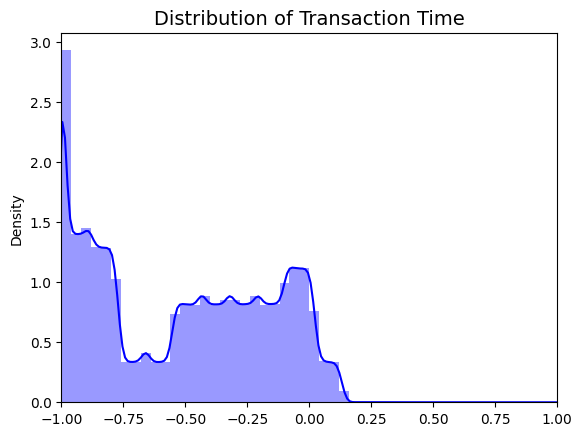

In [23]:
time_val = df_normalized['Timestamp'].values
sns.distplot(time_val, color='b')
plt.title('Distribution of Transaction Time', fontsize=14)
plt.xlim([min(time_val), max(time_val)])

plt.show()

In [24]:
from sklearn.model_selection import KFold, StratifiedKFold

X = df_normalized.drop('Is_Laundering', axis=1)
y = df_normalized['Is_Laundering']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    original_Xtrain = original_Xtrain.values
    original_Xtest = original_Xtest.values
    original_ytrain = original_ytrain.values
    original_ytest = original_ytest.values


    train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
    test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
    print('-' * 100)

    print('Label Distributions: \n')
    print(train_counts_label/ len(original_ytrain))
    print(test_counts_label/ len(original_ytest))

Train: [1015216 1015217 1015218 ... 5078333 5078334 5078335] Test: [      0       1       2 ... 1640857 1643788 1644721]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99898072 0.00101928]
[0.99897998 0.00102002]
Train: [      0       1       2 ... 5078333 5078334 5078335] Test: [1015216 1015217 1015218 ... 2284009 2284931 2285027]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99898047 0.00101953]
[0.99898097 0.00101903]
Train: [      0       1       2 ... 5078333 5078334 5078335] Test: [2030816 2030817 2030818 ... 3208454 3208819 3214577]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99898047 0.00101953]
[0.99898097 0.00101903]
Train: [      0       1       2 ... 5078333 5078334 5078335] Test: [3046760 3046761 3046762 ... 4296460 4297262 4298091]


In [25]:
df_normalized = df_normalized.sample(frac=1)


fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 1]
non_fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])


new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
2776967,-0.434048,-0.999944,-0.969984,-0.994258,-0.955767,-1.000000,-0.428571,-1.000000,-0.428571,0.333333,0
4172426,-0.104800,0.225618,0.385292,0.338146,0.737316,-1.000000,-0.428571,-1.000000,-0.428571,-0.666667,0
1924336,-0.346610,-0.999343,0.413482,-0.853082,-0.042096,-1.000000,-0.571429,-1.000000,-0.571429,-0.333333,1
3055204,-0.154608,-0.864031,-0.001030,-0.917697,-0.189449,-0.999956,-0.428571,-0.999956,-0.428571,-0.333333,1
2172420,-0.537591,-0.885013,-0.210948,-0.315249,-0.195179,-0.999852,0.571429,-0.999852,0.571429,-0.333333,1


Distribution of the Is_Launderinges in the subsample dataset
0    0.5
1    0.5
Name: Is_Laundering, dtype: float64


<ipython-input-26-31ff3c9cb7a9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=new_df, x='Is_Laundering', palette=colors)


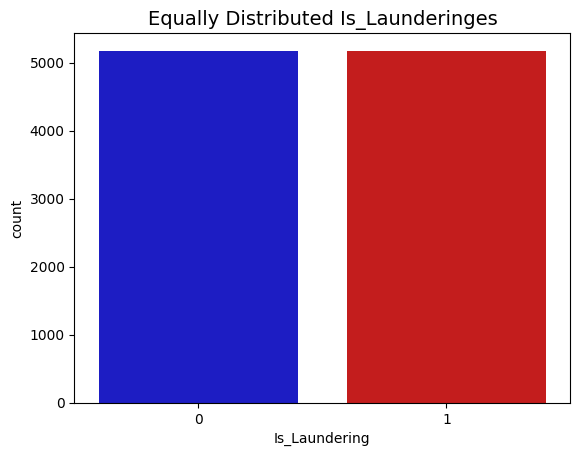

In [26]:
print('Distribution of the Is_Launderinges in the subsample dataset')
print(new_df['Is_Laundering'].value_counts()/len(new_df))

colors = ["#0101DF", "#DF0101"]
sns.countplot(data=new_df, x='Is_Laundering', palette=colors)
plt.title('Equally Distributed Is_Launderinges', fontsize=14)
plt.show()

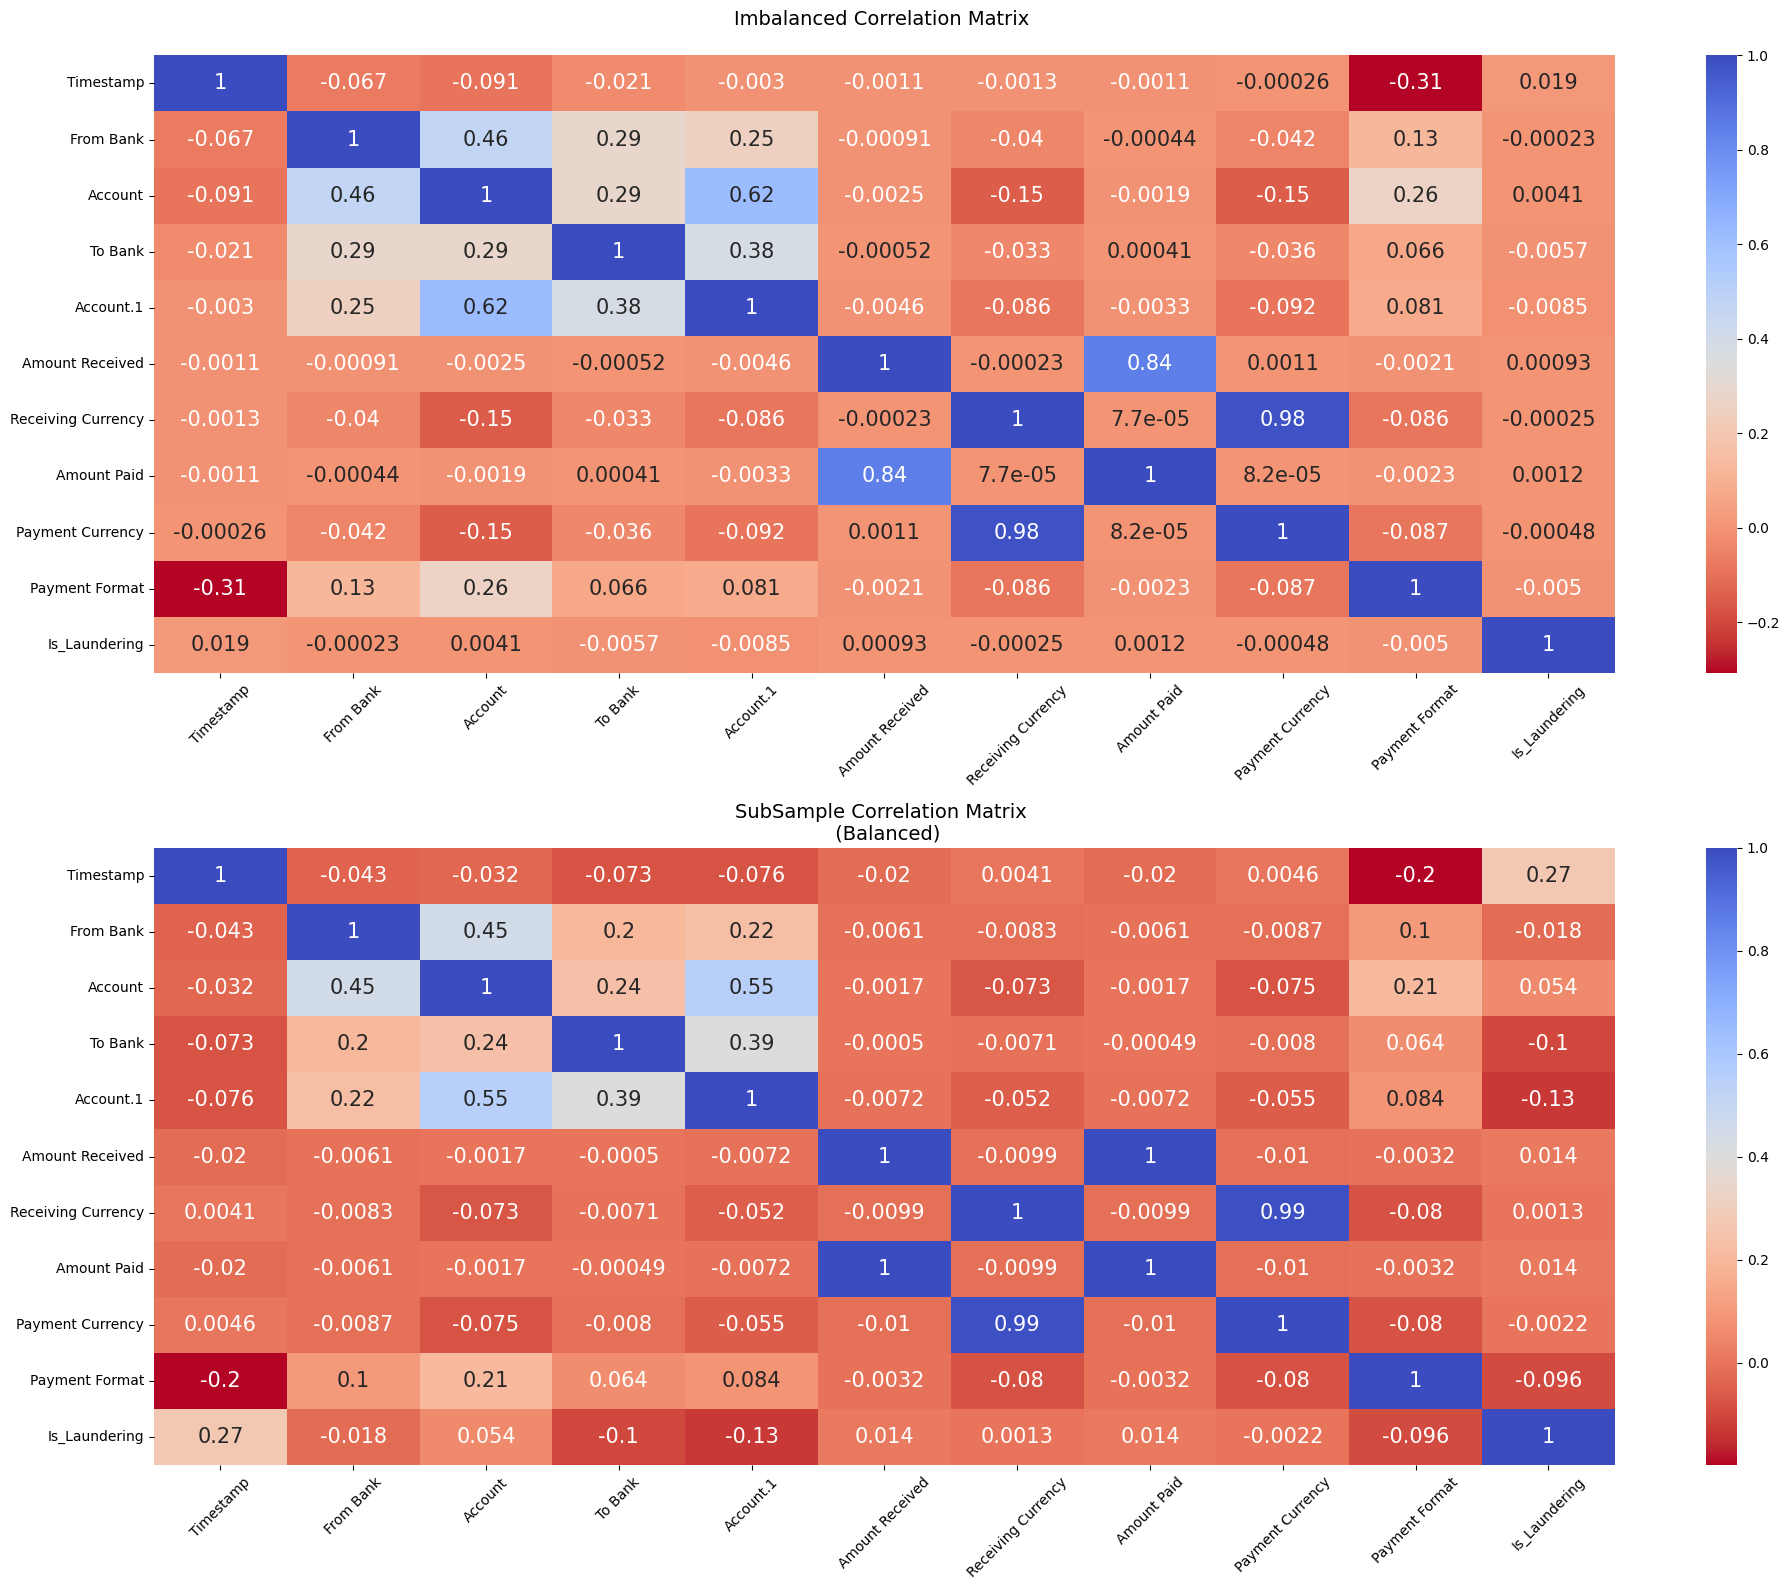

In [27]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,16))


corr = df_normalized.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n ", fontsize=14)
ax1.tick_params(axis='x', labelrotation=45) # rotate x-axis labels


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (Balanced)', fontsize=14)
ax2.tick_params(axis='x', labelrotation=45) # rotate x-axis labels
plt.tight_layout()
plt.show()


<ipython-input-28-b55c77cd82a1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Is_Laundering", y="Timestamp", data=new_df, palette=colors, ax=axes[0])
<ipython-input-28-b55c77cd82a1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Is_Laundering", y="Payment Format", data=new_df, palette=colors, ax=axes[1])


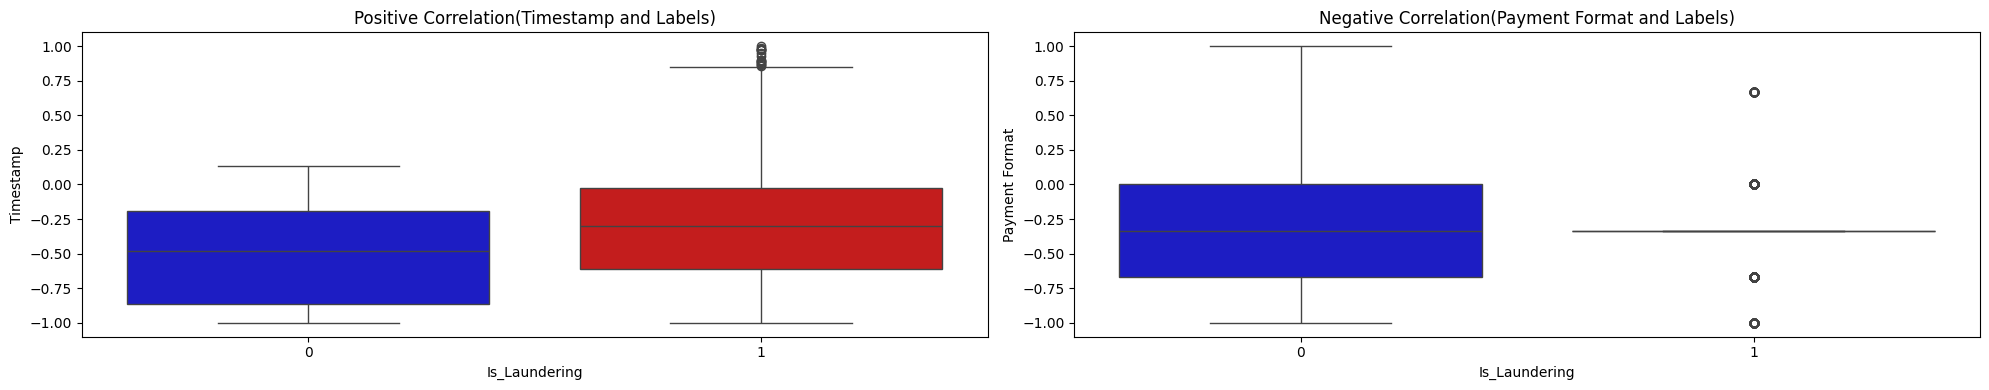

In [28]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))

sns.boxplot(x="Is_Laundering", y="Timestamp", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Positive Correlation(Timestamp and Labels)')

sns.boxplot(x="Is_Laundering", y="Payment Format", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Negative Correlation(Payment Format and Labels)')

plt.tight_layout()
plt.show()

In [29]:
fig1 = px.scatter(new_df, x="Timestamp", y="Is_Laundering")
fig2 = px.scatter(new_df, x="Payment Format", y="Is_Laundering")
fig1.show()
fig2.show()

<ipython-input-30-855996e6b06e>:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




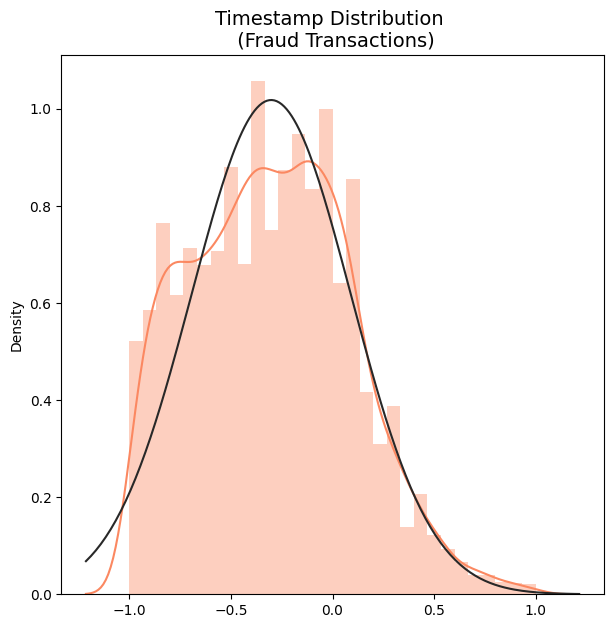

In [30]:
from scipy.stats import norm

f, ax = plt.subplots(figsize=(7, 7))

Timestamp_fraud_dist = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')
ax.set_title('Timestamp Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [31]:
Timestamp_fraud = new_df['Timestamp'].loc[new_df['Is_Laundering'] == 1].values
q25, q75 = np.percentile(Timestamp_fraud, 25), np.percentile(Timestamp_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
Timestamp_iqr = q75 - q25
print('iqr: {}'.format(Timestamp_iqr))

Timestamp_cut_off = Timestamp_iqr * 1.5
Timestamp_lower, Timestamp_upper = q25 - Timestamp_cut_off, q75 + Timestamp_cut_off
print('Cut Off: {}'.format(Timestamp_cut_off))
print('Timestamp Lower: {}'.format(Timestamp_lower))
print('Timestamp Upper: {}'.format(Timestamp_upper))

outliers = [x for x in Timestamp_fraud if x < Timestamp_lower or x > Timestamp_upper]
print('Feature Timestamp Outliers for Fraud Cases: {}'.format(len(outliers)))
print('Timestamp outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['Timestamp'] > Timestamp_upper) | (new_df['Timestamp'] < Timestamp_lower)].index)

new_df.head()

Quartile 25: -0.608767381569578 | Quartile 75: -0.023411108492382482
iqr: 0.5853562730771955
Cut Off: 0.8780344096157933
Timestamp Lower: -1.4868017911853713
Timestamp Upper: 0.8546233011234108
Feature Timestamp Outliers for Fraud Cases: 16
Timestamp outliers:[0.9764317699741696, 0.9699112263338066, 0.9292953099225087, 1.0, 0.9699112263338066, 0.8956713017519178, 0.9704611517008743, 0.9842878466497496, 0.8729672401605058, 0.8669180611204865, 0.8860083274416866, 0.8919789457145271, 0.9027417707598033, 0.8555267499414185, 0.9530992222485111, 0.8765024746644485]


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
2776967,-0.434048,-0.999944,-0.969984,-0.994258,-0.955767,-1.000000,-0.428571,-1.000000,-0.428571,0.333333,0
4172426,-0.104800,0.225618,0.385292,0.338146,0.737316,-1.000000,-0.428571,-1.000000,-0.428571,-0.666667,0
1924336,-0.346610,-0.999343,0.413482,-0.853082,-0.042096,-1.000000,-0.571429,-1.000000,-0.571429,-0.333333,1
3055204,-0.154608,-0.864031,-0.001030,-0.917697,-0.189449,-0.999956,-0.428571,-0.999956,-0.428571,-0.333333,1
2172420,-0.537591,-0.885013,-0.210948,-0.315249,-0.195179,-0.999852,0.571429,-0.999852,0.571429,-0.333333,1


<ipython-input-32-003cc45612a0>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0.5, 0.25, 'Fewer extreme \n outliers')

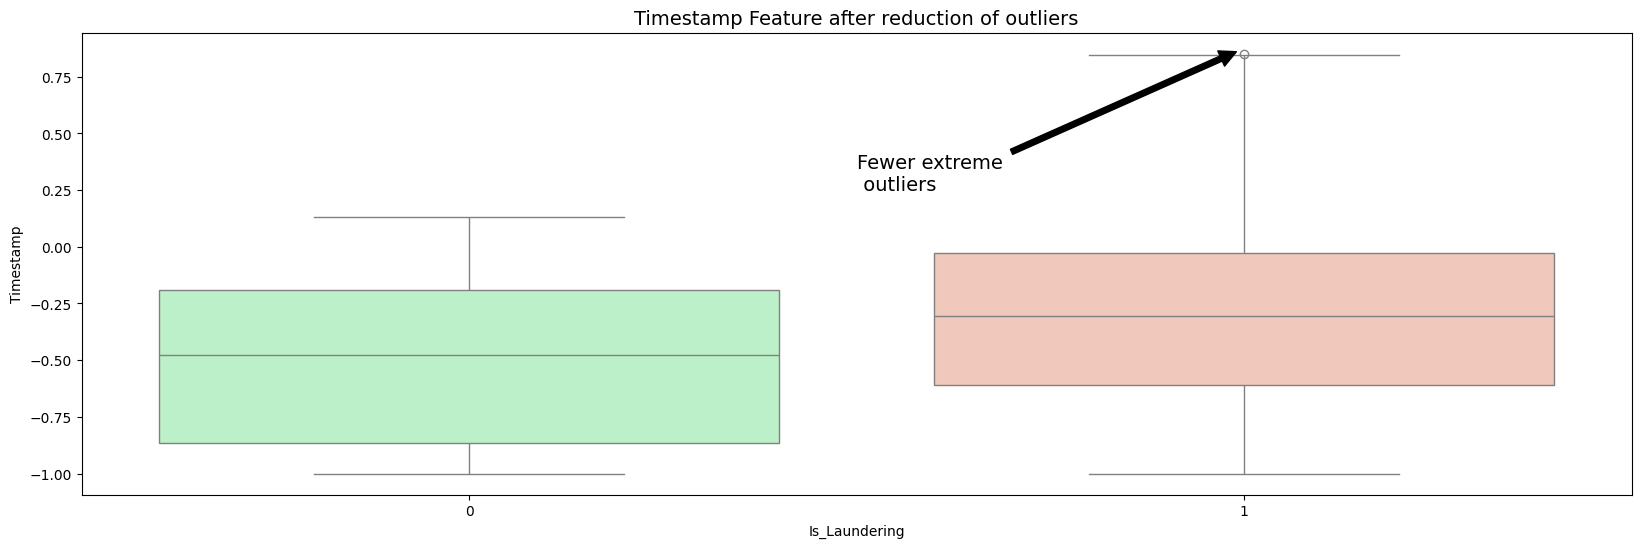

In [32]:
f,ax1 = plt.subplots(figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
sns.boxplot(x="Is_Laundering", y="Timestamp", data=new_df,ax=ax1, palette=colors)
ax1.set_title("Timestamp Feature after reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.99, 0.86), xytext=(0.5, 0.25),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def run(data):
    # Undersampling before cross validating (prone to overfit)
    X = data.drop('Is_Laundering', axis=1)
    y = data['Is_Laundering']

    # Our data is already scaled we should split our training and test sets
    from sklearn.model_selection import train_test_split

    # This is explicitly used for undersampling.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Turn the values into an array for feeding the classification algorithms.
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    # Let's implement simple classifiers
    classifiers = {
        "LogisiticRegression": LogisticRegression(),
        "KNearest": KNeighborsClassifier(),
        "Support Vector Classifier": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier()
    }

    # Wow our scores are getting even high scores even when applying cross validation.
    from sklearn.model_selection import cross_val_score

    for key, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        training_score = cross_val_score(classifier, X_train, y_train, cv=5)
        print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
        test_score = classifier.score(X_test, y_test)
        print("Classifiers: ", classifier.__class__.__name__, "Has a test score of", round(test_score, 2) * 100, "% accuracy score\n")

In [34]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 1.3e+02 s
PCA took 0.021 s
Truncated SVD took 0.03 s


In [35]:
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_tsne_and_pca = PCA(n_components=2, random_state=42).fit_transform(X_reduced_tsne)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

T-SNE took 1e+02 s
PCA took 0.017 s


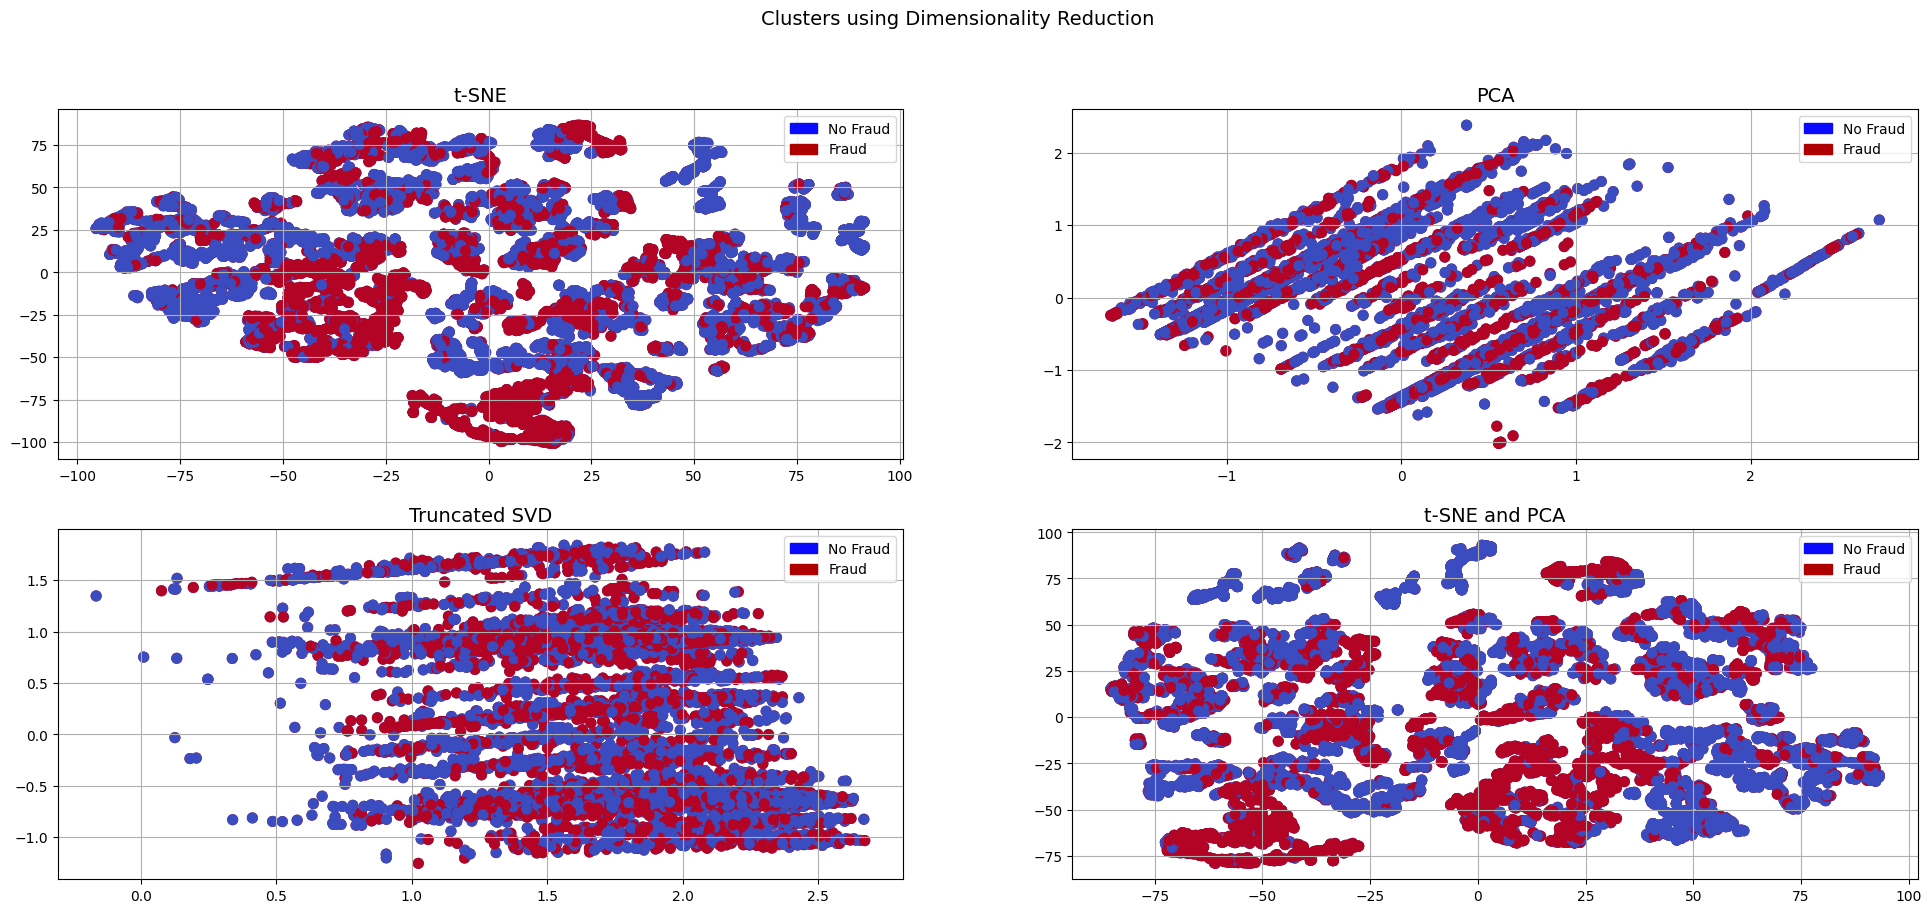

In [36]:
import matplotlib.patches as mpatches

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24,10))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

# t-SNE and PCA
ax4.scatter(X_reduced_tsne_and_pca[:,0], X_reduced_tsne_and_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax4.scatter(X_reduced_tsne_and_pca[:,0], X_reduced_tsne_and_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax4.set_title('t-SNE and PCA', fontsize=14)

ax4.grid(True)

ax4.legend(handles=[blue_patch, red_patch])

plt.show()

In [37]:
run(new_df)

Classifiers:  LogisticRegression Has a training score of 62.0 % accuracy score
Classifiers:  LogisticRegression Has a test score of 63.0 % accuracy score

Classifiers:  KNeighborsClassifier Has a training score of 83.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a test score of 85.0 % accuracy score

Classifiers:  SVC Has a training score of 82.0 % accuracy score
Classifiers:  SVC Has a test score of 85.0 % accuracy score

Classifiers:  DecisionTreeClassifier Has a training score of 86.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a test score of 87.0 % accuracy score



In [38]:
new_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
2776967,-0.434048,-0.999944,-0.969984,-0.994258,-0.955767,-1.000000,-0.428571,-1.000000,-0.428571,0.333333,0
4172426,-0.104800,0.225618,0.385292,0.338146,0.737316,-1.000000,-0.428571,-1.000000,-0.428571,-0.666667,0
1924336,-0.346610,-0.999343,0.413482,-0.853082,-0.042096,-1.000000,-0.571429,-1.000000,-0.571429,-0.333333,1
3055204,-0.154608,-0.864031,-0.001030,-0.917697,-0.189449,-0.999956,-0.428571,-0.999956,-0.428571,-0.333333,1
2172420,-0.537591,-0.885013,-0.210948,-0.315249,-0.195179,-0.999852,0.571429,-0.999852,0.571429,-0.333333,1


[0]	train-logloss:0.62458	train-error:0.08851	test-logloss:0.62681	test-error:0.11025
[1]	train-logloss:0.56543	train-error:0.07497	test-logloss:0.57125	test-error:0.10687
[2]	train-logloss:0.51597	train-error:0.06880	test-logloss:0.52559	test-error:0.10251
[3]	train-logloss:0.47323	train-error:0.06542	test-logloss:0.48602	test-error:0.10106
[4]	train-logloss:0.43701	train-error:0.06445	test-logloss:0.45308	test-error:0.09961
[5]	train-logloss:0.40507	train-error:0.06046	test-logloss:0.42480	test-error:0.10010
[6]	train-logloss:0.37732	train-error:0.05998	test-logloss:0.39976	test-error:0.09720
[7]	train-logloss:0.35299	train-error:0.05852	test-logloss:0.37897	test-error:0.10010
[8]	train-logloss:0.33084	train-error:0.05707	test-logloss:0.36188	test-error:0.09913
[9]	train-logloss:0.31135	train-error:0.05478	test-logloss:0.34557	test-error:0.09671
[10]	train-logloss:0.29311	train-error:0.05429	test-logloss:0.32999	test-error:0.09768
[11]	train-logloss:0.27774	train-error:0.05308	test-l

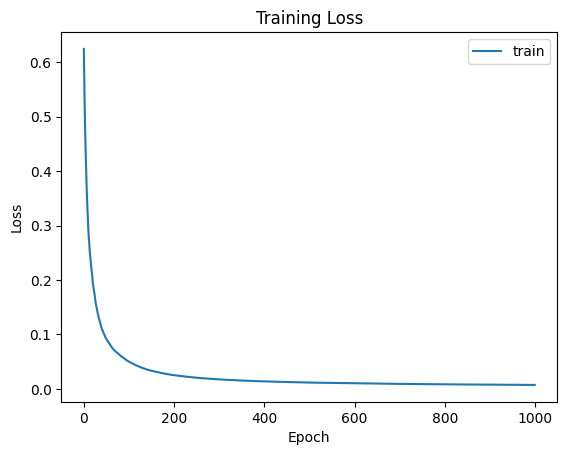

In [39]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

# Split the dataset into features and target variable
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1,
    'max_depth': 16,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1
}

# Train the XGBoost model and record the evaluation results
num_rounds = 1000
watchlist = [(dtrain, 'train'), (dtest, 'test')]
eval_results = {}
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, evals_result=eval_results)

# Evaluate the XGBoost model
y_pred = bst.predict(dtest)
y_pred = np.round(y_pred)
test_score = accuracy_score(y_test, y_pred)
print("XGBoost has a test score of", round(test_score, 2) * 100, "% accuracy score")

# Extract the training loss from the evaluation results
train_loss = eval_results['train']['logloss']

# Plot the training loss curve
plt.plot(train_loss, label='train')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()